In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import yaml

import matplotlib.pyplot as plt

In [2]:
REGIONS_CONFIG = "regions_definition_config.yaml"

def is_nan(value):
    return math.isnan(float(value))

def read_osm_config(*args):
    """
    Read values from the regions config file based on provided key arguments.

    Parameters
    ----------
    *args : str
        One or more key arguments corresponding to the values to retrieve
        from the config file. Typical arguments include "world_iso",
        "continent_regions", "iso_to_geofk_dict", and "osm_clean_columns".

    Returns
    -------
    tuple or str or dict
        If a single key is provided, returns the corresponding value from the
        regions config file. If multiple keys are provided, returns a tuple
        containing values corresponding to the provided keys.

    Examples
    --------
    >>> values = read_osm_config("key1", "key2")
    >>> print(values)
    ('value1', 'value2')

    >>> world_iso = read_osm_config("world_iso")
    >>> print(world_iso)
    {"Africa": {"DZ": "algeria", ...}, ...}
    """
    if "__file__" in globals():
        base_folder = os.path.dirname(__file__)
        if not os.path.exists(os.path.join(base_folder, "configs")):
            base_folder = os.path.dirname(base_folder)
    else:
        base_folder = os.getcwd()
    osm_config_path = os.path.join(base_folder, "configs", REGIONS_CONFIG)
    with open(osm_config_path, "r") as f:
        osm_config = yaml.safe_load(f)
    if len(args) == 0:
        return osm_config
    elif len(args) == 1:
        return osm_config[args[0]]
    else:
        return tuple([osm_config[a] for a in args])

def read_geojson(fn, cols=[], dtype=None, crs="EPSG:4326"):
    """
    Function to read a geojson file fn. When the file is empty, then an empty
    GeoDataFrame is returned having columns cols, the specified crs and the
    columns specified by the dtype dictionary it not none.

    Parameters:
    ------------
    fn : str
        Path to the file to read
    cols : list
        List of columns of the GeoDataFrame
    dtype : dict
        Dictionary of the type of the object by column
    crs : str
        CRS of the GeoDataFrame
    """
    # if the file is non-zero, read the geodataframe and return it
    if os.path.getsize(fn) > 0:
        return gpd.read_file(fn)
    else:
        # else return an empty GeoDataFrame
        df = gpd.GeoDataFrame(columns=cols, geometry=[], crs=crs)
        if isinstance(dtype, dict):
            for k, v in dtype.items():
                df[k] = df[k].astype(v)
        return df

def save_to_geojson(df, fn):
    if os.path.exists(fn):
        os.unlink(fn)  # remove file if it exists

    # save file if the (Geo)DataFrame is non-empty
    if df.empty:
        # create empty file to avoid issues with snakemake
        with open(fn, "w") as fp:
            pass
    else:
        # save file
        df.to_file(fn, driver="GeoJSON")

In [3]:
osm_clean_columns = read_osm_config("osm_clean_columns")

gdf_original = read_geojson(
    "SEA_AIMS/all_clean_lines_original.geojson",
    osm_clean_columns["line"].keys(),
    dtype=osm_clean_columns["line"],
)

gdf_internal = read_geojson(
    "SEA_AIMS/custom_int_lines.geojson",
    osm_clean_columns["line"].keys(),
    dtype=osm_clean_columns["line"],
)

gdf_EXIST = read_geojson(
    "SEA_EXIST/custom_ext_lines.geojson",
    osm_clean_columns["line"].keys(),
    dtype=osm_clean_columns["line"],
)

gdf_AIMS = read_geojson(
    "SEA_AIMS/custom_ext_lines.geojson",
    osm_clean_columns["line"].keys(),
    dtype=osm_clean_columns["line"],
)

gdf_IRENA = read_geojson(
    "SEA_IRENA/custom_ext_lines.geojson",
    osm_clean_columns["line"].keys(),
    dtype=osm_clean_columns["line"],
)

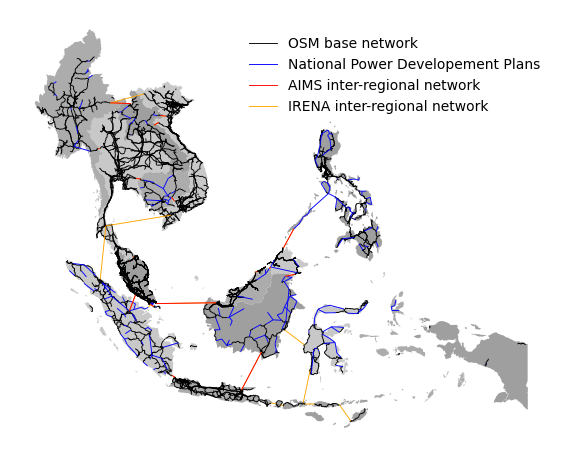

In [6]:
RDIR = "SEA_AIMS_2050/"

country_shapes = gpd.read_file("../../../pypsa-earth/resources/" + RDIR + "shapes/country_shapes.geojson").set_index("name")

color_country_grey = {
    "MM": "#acacac", # Grey
    "TH": "#c8c8c8", # Light
    "Peninsular/MY": "#9f9f9f", # Dark
    "Sumatra/ID": "#c8c8c8", # Light
    "LA": "#9f9f9f", # Dark
    "SG": "#acacac", # Grey
    "KH": "#acacac", # Grey
    "VN": "#c8c8c8", # Light
    "Java-Bali/ID": "#acacac", # Grey
    "Sarawak/MY": "#acacac", # Grey
    "Kalimantan/ID": "#9f9f9f", # Dark
    "BN": "#9f9f9f", # Dark
    "Sabah/MY": "#c8c8c8", # Light
    "Nusa-Tenggara/ID": "#9f9f9f", # Dark
    "Sulawesi/ID": "#c8c8c8", # Light
    "PH": "#9f9f9f", # Dark
    "Maluku/ID": "#acacac", # Grey
    "Papua/ID": "#9f9f9f", # Dark
    }

ax = country_shapes.plot(figsize=(7,7), color=[color_country_grey[a] for a in country_shapes.index])
ax.axis('off')

lw = 0.65

gdf_original.plot(ax=ax, color="black", linewidth=lw)
gdf_internal.plot(ax=ax, color="blue", linewidth=lw)
gdf_IRENA.plot(ax=ax, color="orange", linewidth=lw)
gdf_AIMS.plot(ax=ax, color="red", linewidth=lw)
gdf_EXIST.plot(ax=ax, color="blue", linewidth=lw)

from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color="black", lw=lw),
                Line2D([0], [0], color="blue", lw=lw),
                Line2D([0], [0], color="red", lw=lw),
                Line2D([0], [0], color="orange", lw=lw)
               ]

ax.legend(custom_lines, ['OSM base network', 'National Power Developement Plans', 'AIMS inter-regional network','IRENA inter-regional network'],
         frameon=False,loc="center right",bbox_to_anchor=(1, 0.85))

#plt.tight_layout()
plt.savefig("clean_line_network.svg",bbox_inches="tight")